In [42]:
from qiskit import QuantumCircuit, execute, Aer, QuantumRegister, ClassicalRegister, transpile, assemble
from qiskit.quantum_info.operators import Operator
from cmath import exp
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit.library import QFT
from qiskit.circuit import Parameter
from qiskit.visualization import plot_histogram
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
from permutation_indexing import indexing_unitary, unindexing_unitary, permutation_to_integer_repr

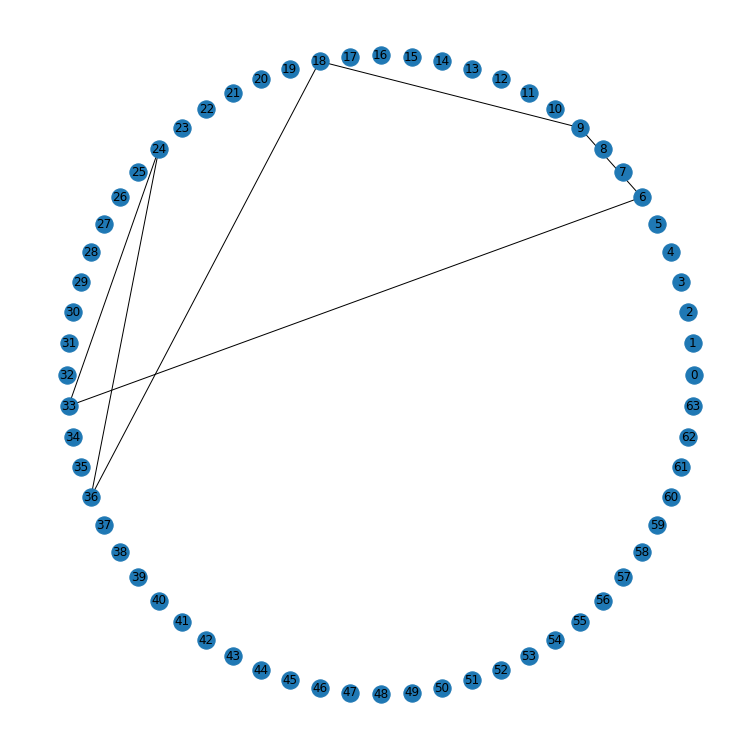

In [43]:
def restricted_circulant_graph(size, connections, values):
    rtn = nx.Graph()
    rtn.add_nodes_from(range(0,size))
    edges = []
    for distance in connections:
        edges += [(values[i], values[(i+distance)%len(values)]) for i in range(len(values))]
    rtn.add_edges_from(edges)
    return rtn

solution_space_G = restricted_circulant_graph(2**6, [1], [
        permutation_to_integer_repr([0,1,2]),
        permutation_to_integer_repr([0,2,1]),
        permutation_to_integer_repr([1,0,2]),
        permutation_to_integer_repr([2,1,0]),
        permutation_to_integer_repr([1,2,0]),
        permutation_to_integer_repr([2,0,1])
    ])
plt.figure(3,figsize=(10,10)) 
nx.draw_circular(solution_space_G, with_labels=True)

In [44]:
"""Get eigenvalues"""
data = np.linalg.eig(
    nx.adjacency_matrix(solution_space_G).todense()
)
eigenvalues = list(data[0])
print(eigenvalues)

[-1.9999999999999996, 1.9999999999999991, 1.0, -1.0000000000000007, -1.0, 0.9999999999999998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


C:\Users\antsg\AppData\Local\Temp\ipykernel_23400\1853367753.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  nx.adjacency_matrix(solution_space_G).todense()


In [45]:
"""Make diagonal operator and convert to circuit"""
def parameterized_lambda(time, eigenvalues):
    diagonalized_matrix = []
    for col in range(len(eigenvalues)):
        diagonalized_matrix.append([])
        for row in range(len(eigenvalues)):
            if row == col:
                diagonalized_matrix[-1].append(exp(1j * time * eigenvalues[row]))
            else:
                diagonalized_matrix[-1].append(0)
    return Operator(diagonalized_matrix)

In [46]:
"""Quality function for any graph"""
def quality(solution):
    rtn = 0
    for i in range(len(solution)//2):
        rtn += solution[i] == '1' or solution[i] == 1
    return rtn


'''Computes average quality of all the bitstrings outputted by the circuit, accounting for multiplicity'''
def compute_expectation(counts):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = quality(bitstring)
        avg += obj * count
        sum_count += count
        
    return avg/sum_count

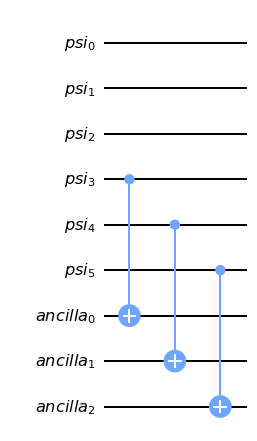

In [47]:
def quality_quantum_circuit():
    problem_register = QuantumRegister(6, name='psi')
    ancilla_register = QuantumRegister(3, name='ancilla')
    qc = QuantumCircuit(problem_register, ancilla_register, name = ' quality')
    for i in range(3):
        qc.cx(3+i,6+i)
    return qc
quality_quantum_circuit().draw('mpl')

In [48]:
'''Create exp gates as shown in figure 1 of the paper'''
def exp_gate(i, gamma):
    return Operator(
        [[1, 0],
         [0, exp(-1j * (2**i) * gamma)]]
    )

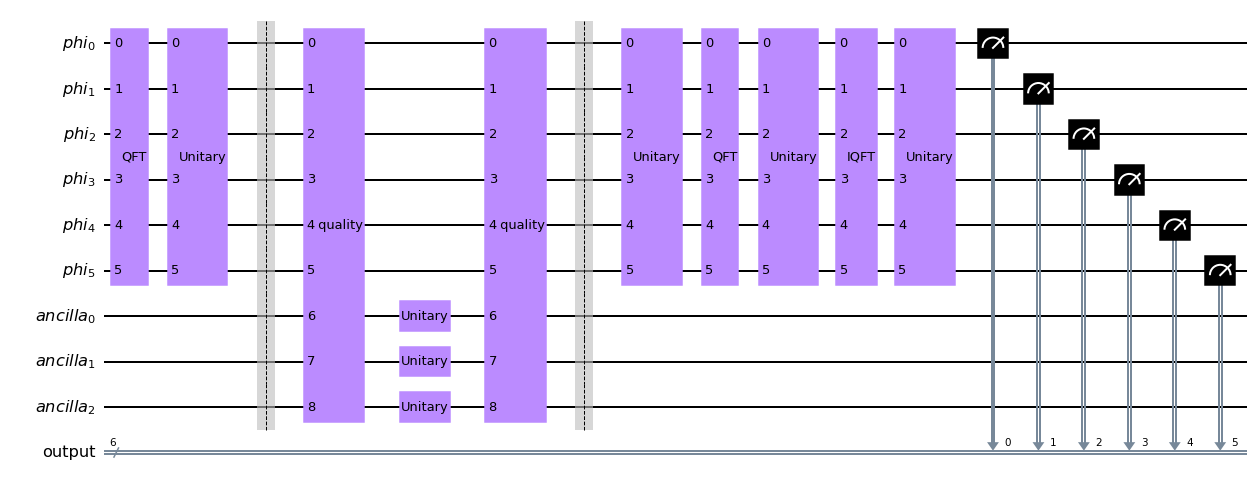

In [49]:
'''Create a depth 1 QWOA circuit based on input parameters'''
def create_circuit(params, eigenvalues):
    
    # extract parameters
    gamma = params[0]
    time = params[1]

    # define circuit
    problem_register = QuantumRegister(6, name='phi')
    ancilla_register = QuantumRegister(3, name='ancilla')
    output_register = ClassicalRegister(6, name='output')
    qc = QuantumCircuit(problem_register, ancilla_register, output_register)
    
    # initialize to a superposition over all valid states (in the case of maxcut, all states are valid)
    qft_setup = QFT(6, inverse=False).to_instruction()
    qc.append(qft_setup, [0,1,2,3,4,5])
    qc.append(unindexing_unitary(3), [0,1,2,3,4,5])

    qc.barrier()

    # compute quality
    quality_gate = quality_quantum_circuit().to_gate()
    qc.append(quality_gate, [0,1,2,3,4,5,6,7,8])
    
    # apply gamma rotation to ancilla qubits
    for i in range(0,3):
        unitary = exp_gate(i, gamma)
        qc.append(unitary, [6+i])
    
    # reapply quality gate
    qc.append(quality_gate, [0,1,2,3,4,5,6,7,8])
    
    qc.barrier()
    
    #Set up fourier transform gates, look at operator matrix
    inv_qft_gate = QFT(6, inverse=True).to_instruction()  
    qft_gate = QFT(6, inverse=False).to_instruction()

    # quantum fourier transform on the solution phi
    qc.append(indexing_unitary(3), [0,1,2,3,4,5])

    qc.append(qft_gate, [0,1,2,3,4,5])
    
    lambda_gate = parameterized_lambda(time, eigenvalues)

    qc.append(lambda_gate, [0,1,2,3,4,5])

    qc.append(inv_qft_gate, [0,1,2,3,4,5])

    qc.append(unindexing_unitary(3), [0,1,2,3,4,5])

    qc.measure([0,1,2,3,4,5],[0,1,2,3,4,5])

    return qc
    
create_circuit([1, 1], eigenvalues).draw('mpl')

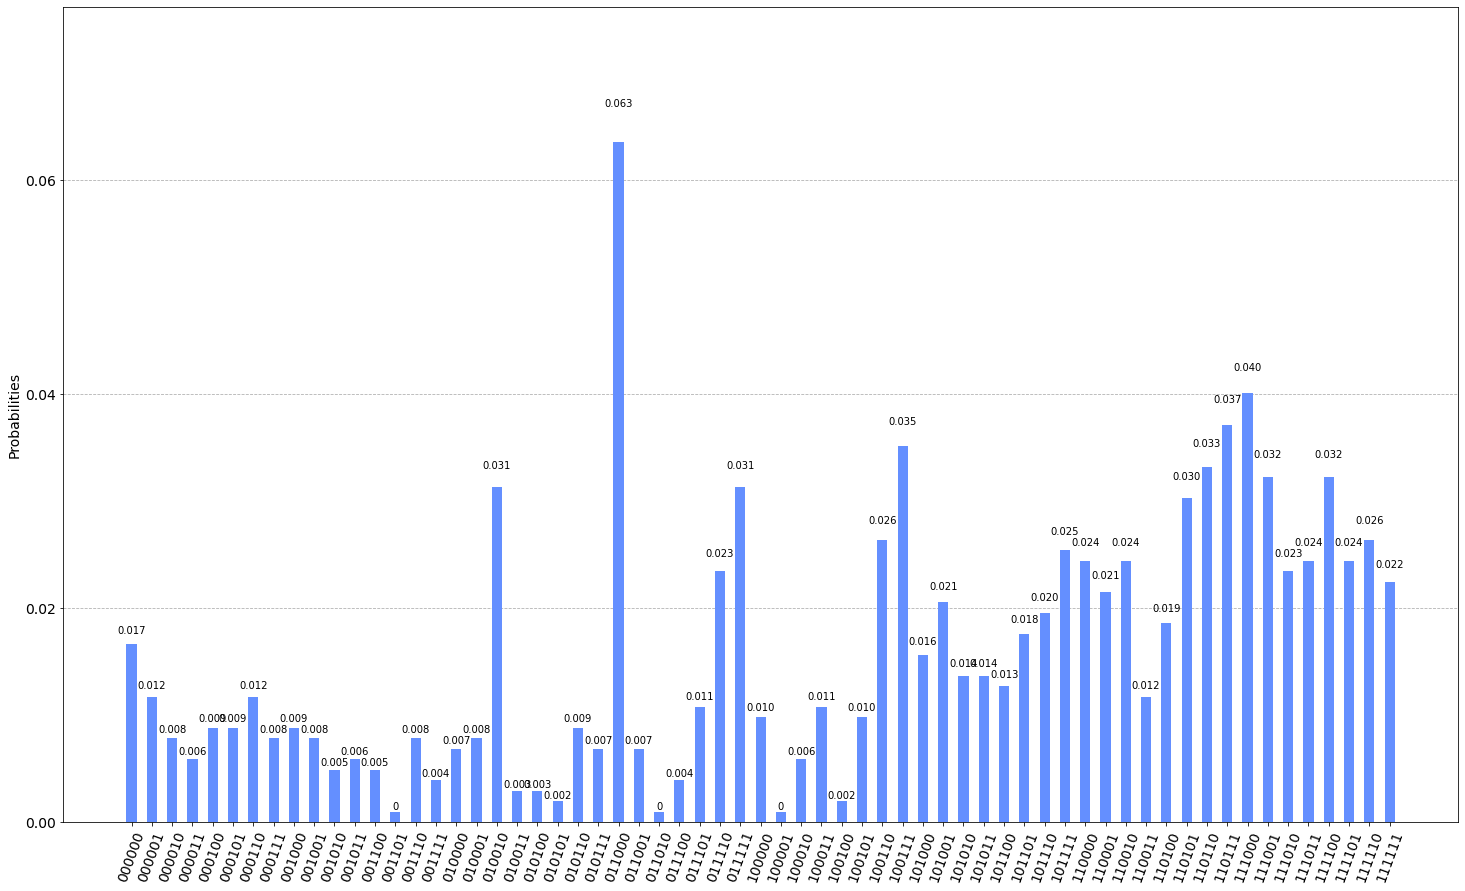

In [50]:
"""Simulate circuit and train parameters"""
backend = Aer.get_backend('qasm_simulator')
backend.shots = 512

def execute_circ(theta):
    qc = create_circuit(theta, eigenvalues)
    test = transpile(qc, backend)
    qobj = assemble(test)
    counts = backend.run(qobj, seed_simulator=10, nshots=512).result().get_counts()
    return -compute_expectation(counts)
    
res = minimize(execute_circ, [1.0, 1.0], method='COBYLA')

qc_res = create_circuit(res.x, eigenvalues)

test = transpile(qc_res, backend)
qobj = assemble(test)
counts = backend.run(qobj, seed_simulator=10).result().get_counts()

plot_histogram(counts,figsize=(25, 15))

In [51]:
def countour_plot (cost_function, resolution=32):
    grid_values = np.linspace(0, np.pi * 2, num=resolution)
    cost_values = np.zeros((resolution, resolution))
    row = column = 0
    for gamma in grid_values:
        for time in grid_values:
            cost_values[row][column] = cost_function([gamma, time])
            column += 1
        row += 1
        column = 0
    plt.figure(figsize=(15,15)) 
    plt.contourf(grid_values, grid_values, cost_values)
    plt.axis('scaled')
    plt.colorbar()
    plt.show()

countour_plot(execute_circ, 42)

KeyboardInterrupt: 